### Sketching technique: Regression : l2 norm ratio 
#### Leverage score
#### Kmeans (Local Landmark Selection)
#### Kmeans++ (probablistic || parallel KMeans++)
#### Time taken by each algorithm
#### Uniform Sampling

##### the reduced rows are taken in format: s=[row/2,row/4,row/8,row/16,row/32,row/64]

## ------------------------------------

#### Few important libraries
###### sklearn.utils.extmath.randomized_svd


#### ----------------------------------------
##### axis = 0 across columns
##### axis = 1/-1 across row
##### np.sum(np.abs(x)**2,axis=-1/1) for computing l2norm of each row of matrix

### Citation

##### Enzo Michelangeli, style changes by josef-pktd code for multivariate t ditribution is used : found on stack overflow : https://stackoverflow.com/questions/41957633/sample-from-a-multivariate-t-distribution-python


### Synthetic Data Creation
#### Reference page15: https://arxiv.org/pdf/1306.5362.pdf


##### 1.Nearly uniform leverage scores (GA)
##### 2.Moderately nonuniform leverage scores (T3).
##### 3.Very nonuniform leverage scores (T1)

#### Library Imports

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit,time
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import math
from random import*
from numpy.testing import assert_almost_equal

#### Histogram Plot

In [3]:
## plotting
def plotHist(l):
        mini = min(l)
        maxi = max(l)
        b = [mini,2*mini,3*mini,4*mini,5*mini,6*mini,7*mini,8*mini]
        plt.hist(l,bins=b,range=[mini, maxi],cumulative=False)
        plt.title("Leverage Score")
        plt.xlabel("LeverageScore")
        plt.ylabel("Frequency")

In [2]:
def plotH(l):
        plt.figure(figsize=(10,10))
        plt.xticks(np.arange(min(l), max(l),0.0015))
        plt.hist(l)
        plt.title("Leverage Score")
        plt.xlabel("LeverageScore")
        plt.ylabel("Frequency")

#### Inputs

In [12]:
def inputs():
    n = int(input('Enter the column dimension (# fo row): '))
    d = int(input('Enter the row dimension(# of column > 20): '))
    #osv = int(input('Oversampling factor l: '))
    return n,d

#### Execution

In [45]:
n,d= inputs()
row = n
#s = [row/16,row/25,row/32,row/40,row/50,row/64,row/80,row/90,row/100]
#s = [row/25,row/32,row/40,row/50,row/64,row/80]
s=[row/25,row/32,row/40]
s = [round(x) for x in s]
factor = [1]
l2Matrix = np.zeros((len(factor),len(s)))

##### Nearly Uniform Leverage Score

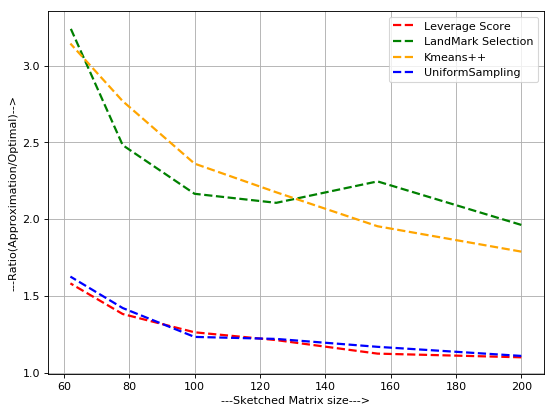

In [31]:
A,b = GA(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
execute(A,b)

##### Execution : Moderaltely Uniform Leverage Score

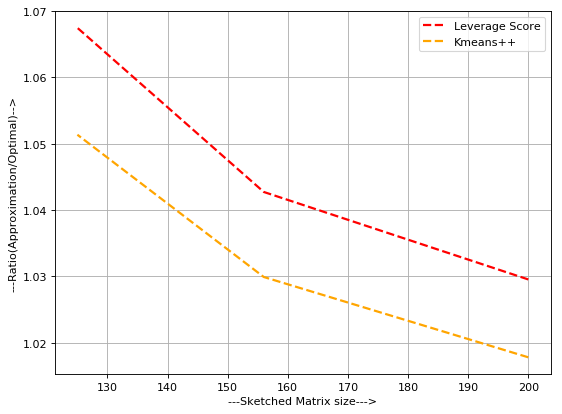

In [49]:
A,b = T3(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
execute(A,b)

##### Execution : Very Non-Uniform Leverage Score

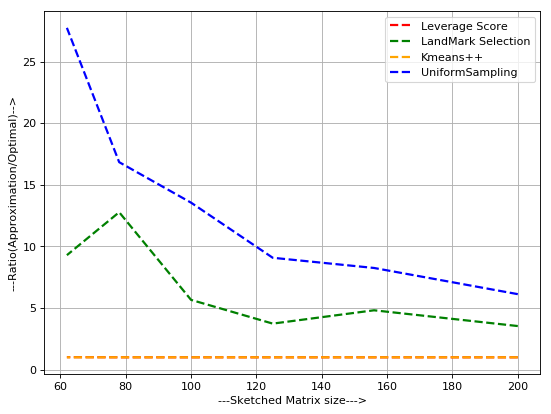

In [34]:
A,b=T1(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
execute(A,b)

##### Execution Function

In [37]:
def execute(A,b):
    #r1,r2,r3,r4= controller2(A,b)
    #r1,r2,r3,r4,r5 = controller2(A,b)
    #plots(s,r1,r2,r3,r4)#,r5)
    r1,r3=controller2(A,b)
    plots(s,r1,r3)

#### Controller

In [36]:
def controller2(A,b):
    r1 = LSS(A,b)
    #r2 = LMS(A,b)
    r3 = KPP(A,b)
    #r4 = USS(A,b)
    #r5 = SKPP(A,b)
    #return r1#,r2,r3,r4#,r5
    return r1,r3

##### Leverage Score Sampling

In [43]:
def LSS(A,b):
    l2norm=list() #for storing l2 norm across various size changes
    ratio = list()
    u,e,vt = np.linalg.svd(A,full_matrices=False)
    leveragescore = np.sum(np.abs(u)**2,axis=1) # for rows the matrix considered is column :
    prob = leveragescore/sum(leveragescore)
    for k in s: # s represent the lsit of number of cluster
        r=0
        for i in range(10):
            index = np.random.choice(row,k,replace = False,p=prob)
            #print(index)
            C = A[index,:] # selcting s rows
            A_sketch = C
            b_sketch = b[index]
            #regression call
            x_tilde = regression(A_sketch,b_sketch)
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    #print(ratio)
    return ratio

##### LandMark Sampling Selection

In [15]:
def LMS(A,b):
    l2norm = list()  # this is for sketched
    ratio = list()
    aug_A = np.c_[A,b]
    for k in s:
        r=0
        for i in range(10):   
            k_cluster=KMeans(n_clusters=k,init='random',n_init=1,random_state=0).fit(aug_A)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1] # placing the first d columns in A sketch
            b_sketch = C[:,-1]  #placing the (d+1)th column in b
            x_tilde = regression(A_sketch,b_sketch)
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
        # only for sketched matrix
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio

##### KMeans ++ Sampling
###### class sklearn.cluster.KMeans(n_clusters=8, init=’k-means++’, n_init=10, max_iter=300, tol=0.0001, precompute_distances=’auto’, verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm=’auto’)[source]

In [41]:
def KPP(A,b):
    l2norm = list()
    ratio = list()
    aug_A = np.c_[A,b]
    for k in s:
        r=0
        for i in range(10):
            k_cluster=KMeans(n_clusters=k,init='k-means++',n_init=1,random_state=0,max_iter=1).fit(aug_A)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1] # placing the first d columns in A sketch
            b_sketch = C[:,-1]#placing the (d+1)th column in b
            x_tilde = regression(A_sketch,b_sketch) 
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio

##### Uniform Sampling

In [17]:
def USS(A,b):
    l2norm = list()  # this is for sketched
    ratio = list()
    for k in s:
        r=0
        for i in range(10):
            index = np.random.choice(row,k)
            A_sketch = A[index,:]# called C also
            b_sketch = b[index]
            x_tilde = regression(A_sketch,b_sketch)
            r+=np.linalg.norm((A.dot(x_tilde)-b),ord=2)
        r/=10
        l2norm.append(r)
    ratio = np.array(l2norm)/np.array(l2normOpt)
    return ratio

##### Regression Model

In [19]:
def regression(A,b):
    regression_model = LinearRegression()
    regression_model.fit(A,b)
    return regression_model.coef_

##### Plotting

In [34]:
def plots(x,y1,y3):#,y2,y3,y4,y5):
    plt.figure(figsize=(8,6),dpi=80)
    plt.plot(x,y1,color="red",linewidth=2.0,linestyle="--",label='Leverage Score')
    #plt.plot(x,y2,color="green",linewidth=2.0,linestyle="--",label='LandMark Selection')
    plt.plot(x,y3,color="orange",linewidth=2.0,linestyle="--",label='Kmeans++')
    #plt.plot(x,y4,color="blue",linewidth=2.0,linestyle="--",label='UniformSampling')
    #plt.plot(x,y5,color="brown",linewidth=2.0,linestyle="--",label='Scalable Kmeans||')
    plt.xlabel('---Sketched Matrix size--->')
    
    plt.ylabel('---Ratio(Approximation/Optimal)-->')
    plt.legend()
    plt.grid(b=True)
    plt.show()

#### Synthetic data : uniform leverage score
##### y = Xw+e
##### Using multivariate distribution : N(1d,C)
##### C = 2*0.5^|i-j|  : covariance matrix
##### w =(1_10;0.1*1_p-20;1_10)_p


#### Nearly Uniform leverage score

In [15]:
def GA(n,d):
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    X = np.random.multivariate_normal(mean,C,(n)) # this is A
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

#### Moderaltely non-uniform leverage score

In [16]:
def T3(n,d):
    df = 3
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    return X,y

#### Very non-uniform leverage score

In [17]:
def T1(n,d):
    df = 1
    C = np.zeros((d,d)) # covariance matrix
    for i in range(d):
        for j in range(d):
            C[i][j] = 2*(0.5**abs(i-j))
    mean = np.ones(d)
    x = np.random.chisquare(df, n)/df
    X = np.random.multivariate_normal(mean,C,(n))
    X = X/np.sqrt(x)[:,None]
    beta = list()
    beta.extend(np.ones(10))
    beta.extend(0.1*np.ones(d-20))
    beta.extend(np.ones(10))
    beta = np.array(beta)
    noise = np.random.normal(loc=0.0,scale =9,size=n)
    y = X.dot(beta) + noise # this is b
    
    return X,y

### Scalable Kmeans

In [48]:
def SKPP(A,b):
    aug_A = np.c_[A,b]
    x=0;
    y=0;
    prob=[]
    global l2Matrix
    global factor,s
    for f in factor:
        for k in s:
            wC= KmeansP(aug_A,f*k)
            k_cluster=KMeans(n_clusters=k,init='k-means++',n_init=1,max_iter=1,random_state=0).fit(wC)
            C = k_cluster.cluster_centers_
            A_sketch = C[:,:-1]
            b_sketch = C[:,-1]
            x_tilde = regression(A_sketch,b_sketch)
            # for plotting purpose
            l2Matrix[x][y]=np.linalg.norm((A.dot(x_tilde))-b,ord=2)
            y+=1
        x+=1
        y=0
    #ratio = np.array(l2norm)/np.array(l2normOpt)
    l2Matrix = l2Matrix/l2normOpt
    return l2Matrix[0][:]

In [24]:
def KmeansP(A,l):
    r,c = A.shape
    # select a uniform point from the n : step1
    index= np.random.choice(r,1);
    C = A[index,:]
    loop=15
    count=0;
    # Calculate probability of each point of x
    for i in range(loop): 
        dist,phi = computeDist(A,C) #-- Calling distance
        #assert_almost_equal(np.sum(np.array(dist)/phi),1)
        dist = np.array(dist)*l #-- scaling the distance with oversampling factor
        prob = dist/phi
        
        #--- Sampling x independently from X with above computed probability
        for j in range(r):
            if(prob[j]>np.random.random_sample()):
                C = np.vstack([C,A[j,:]])
    # loop ends
    # weight computation
    weights = computeWeight(C,A)
    weighted_C = np.multiply(C,weights[:,np.newaxis])
    return weighted_C
    

In [39]:
def computeDist(A,C):
    phi=0
    dist=[]
    for x in A:
        min_dist=np.inf
        for c in C:
            eucd_dist = np.square(np.linalg.norm(abs(x-c),ord=2))
            if(min_dist > eucd_dist):
                min_dist = eucd_dist
        dist.append(min_dist)
        phi += min_dist
    return dist,phi

In [40]:
def computeWeight(C,A):
    row,col = C.shape
    w = np.zeros(row)
    min_index=[]
    for i in range(A.shape[0]):
        min_dist = math.inf
        #nearest=0
        for j in range(row):
            eucd_dist = np.square(np.linalg.norm(A[i]-C[j],ord=2))
            if(min_dist > eucd_dist):
                min_index[:]=[] # emptying list
                min_index.append(j)
                min_dist=eucd_dist
            elif(min_dist == eucd_dist):
                min_index.append(j)
        for j in min_index:
            w[j]+=1
    return w

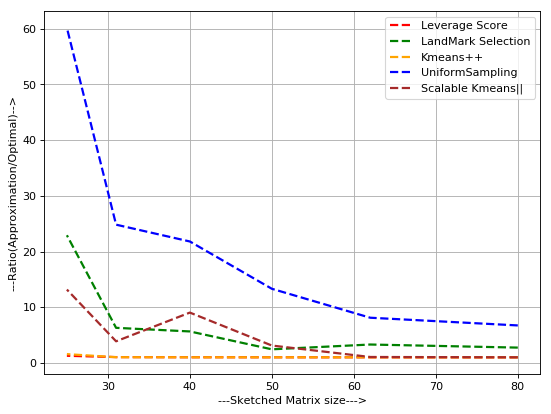

In [51]:
A,b = T3(n,d)
x_opt = regression(A,b)
l2normOpt = np.linalg.norm((A.dot(x_opt)-b),ord=2)
execute(A,b)